# Cell-to-cell communication

<!-- TODO @abyssum: this is copied&pasted from my phd thesis, feel free to rewrite/remove/... -->

Communication between cells is crucial for orchestrating biological functions including immune
response (see section 1.2). However, due to the dissociation of cells for single-cell sequencing,
information about proximity of cells is lost. Therefore, several algorithms have been developed to
infer cell-to-cell communication from gene expression data. In general, these methods consist of a
database of known ligand-receptor pairs and an algorithm to score these pairs based on their gene
expression patterns.
Dimitrov et al. [143] compared 16 ligand-receptor databases and 7 methods including Cell-
PhoneDB [144], CellChatDB [145] and NATMI [146]. They provide a consistent interface to all
methods in the LIANA package [143] and integrated ligand-receptor information from all databases
into Omnipathdb [147]. Due to the lack of a gold standard, the authors assessed the methods and
databases with respect to concordance with spatial proximity and cytokine signaling. While they
found considerable differences both between methods and databases, there was no method that
consistently outperformed the others.
Compared to the methods assessed by Dimitrov et al. [143], NicheNet [148], cytotalk [149],
and SoptSC [150] go one step further by not only considering ligands and receptors (inter-cellular
communication), but also gene regulatory networks within a cell (intracellular communication).
This allows leveraging the expression of a receptor’s downstream target genes to predict cell-cell
interactions.
The methods described above were originally designed to compare cell-to-cell communication
between cell-types. To this end, CellPhoneDB and CellChatDB implement a permutation test
that shuffles cell-type labels. This is useful for understanding the steady state in different tissues,
however, as the single-cell field moves towards perturbation experiments and large-scale atlases
(see section 4.2), methods to assess differential cell-to-cell communication patterns are required.
A simple, yet effective approach has recently been added to CellPhoneDB v3 [151]. Here,
a ligand-receptor pair is considered as potentially perturbed if (1) both receptor and ligand are
expressed in at least 10 % of all cells of source and target cell populations, respectively, and (2) at
least one of the ligand and receptor is differentially expressed. NicheNet requires differentially
expressed ligands/receptors as input which may also stem from comparisons between conditions.
The authors provide a tutorial for differential NicheNet analysis [152]. Both approaches can readily
be combined with DE methods that account for pseudoreplication bias and are robust to dropouts
of lowly expressed genes (see section 1.5.7).

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import scanpy as sc
from toolz.functoolz import pipe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map
import itertools

import atlas_protocol_scripts as aps
# TODO @abyssum: there's aps.tl.CpdbAnalysis

In [3]:
path_adata = "../../data/20_build_atlas/add_additional_datasets/03_update_annotation/artifacts/full_atlas_merged.h5ad"
path_adata_n = "../../data/30_downstream_analyses/neutrophils/subclustering//artifacts/adata_neutrophil_clusters.h5ad"
artifact_dir ="/home/sturm/Downloads/"
path_cpdb = "../../tables/cellphonedb_2022-04-06.tsv"
deseq2_path_prefix = "../../data/30_downstream_analyses/de_analysis/{comparison}/de_deseq2"
deseq2_path_neutro_clusters = "../../data/30_downstream_analyses/de_analysis/neutrophil_subclusters/de_deseq2/neutrophil_subclusters_adata_neutrophil_clusters_neutrophils_DESeq2_result.tsv"

In [4]:
adata = sc.read_h5ad(path_adata)

In [5]:
adata_n = sc.read_h5ad(path_adata_n)

In [6]:
cpdb = pd.read_csv(path_cpdb, sep="\t")

In [7]:
adata_primary_tumor = adata[(adata.obs["origin"] == "tumor_primary")].copy()

In [8]:
immune_cells = [
    "B cell",
    "cDC1",
    "cDC2",
    "DC mature",
    "Macrophage",
    "Macrophage alveolar",
    "Mast cell",
    "Monocyte",
    "Neutrophils",
    "NK cell",
    "pDC",
    "Plasma cell",
    "T cell CD4",
    "T cell CD8",
    "T cell regulatory",
]

In [9]:
cpdb

source  target source_genesymbol target_genesymbol  is_directed  \
0     Q9Y219  P46531              JAG2            NOTCH1            1   
1     O00548  P46531              DLL1            NOTCH1            1   
2     P05019  P08069              IGF1             IGF1R            1   
3     P78504  P46531              JAG1            NOTCH1            1   
4     P41221  Q14332             WNT5A              FZD2            1   
...      ...     ...               ...               ...          ...   
1470  P04628  P16671              WNT1              CD36            1   
1471  P20774  P01911               OGN          HLA-DRB1            1   
1472  Q8NHW4  O15173            CCL4L1            PGRMC2            1   
1473  P41273  A4D1S0            TNFSF9             KLRG2            1   
1474  P49961  P0DMS8            ENTPD1            ADORA3            1   

      is_stimulation  is_inhibition  consensus_direction  \
0                  1              1                    1   
1                  1              0                    1   
2                  1              0                    1   
3                  1              1                    1   
4                  1              1                    1   
...              ...            ...                  ...   
1470               0              0                    0   
1471               0              0                    0   
1472               0              0                    0   
1473               0              0                    0   
1474               0              0                    0   

      consensus_stimulation  consensus_inhibition  \
0                         1                     0   
1                         1                     0   
2                         1                     0   
3                         1                     0   
4                         1                     0   
...                     ...                   ...   
1470                      0                     0   
1471                      0                     0   
1472                      0                     0   
1473                      0                     0   
1474                      0                     0   

                                                sources  \
0     Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...   
1     Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...   
2     Baccin2019;CA1;CellCall;CellChatDB;CellPhoneDB...   
3     ACSN;Baccin2019;BioGRID;CellCall;CellChatDB;Ce...   
4     Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...   
...                                                 ...   
1470          CellPhoneDB;InnateDB;InnateDB_CellPhoneDB   
1471               CellPhoneDB;InnateDB-All_CellPhoneDB   
1472    CellPhoneDB;IMEx_CellPhoneDB;IntAct_CellPhoneDB   
1473               CellPhoneDB;InnateDB-All_CellPhoneDB   
1474                                        CellPhoneDB   

                                             references  
0     Baccin2019:1100613311006130;CellChatDB:2235346...  
1     Baccin2019:1006133;Baccin2019:98194281;CellCha...  
2     Baccin2019:1852007;Baccin2019:2877871;CA1:8408...  
3     ACSN:22330899;ACSN:22363130;Baccin2019:7697721...  
4     Baccin2019:9389482;CellPhoneDB:24032637;CellTa...  
...                                                 ...  
1470                                  InnateDB:25721714  
1471                                                NaN  
1472                                                NaN  
1473                                                NaN  
1474                                                NaN  

[1475 rows x 12 columns]

In [10]:
cpdba = sh.cell2cell.CpdbAnalysis(
    cpdb,
    adata_primary_tumor,
    pseudobulk_group_by=["patient"],
    cell_type_column="cell_type_major",
)

In [13]:
cpdba_coarse = sh.cell2cell.CpdbAnalysis(
    cpdb,
    adata_primary_tumor,
    pseudobulk_group_by=["patient"],
    cell_type_column="cell_type_coarse",
)

# LUAD vs LUSC

In [14]:
de_res_tumor_cells_luad_lusc = (
    pd.read_csv(
        (
            deseq2_path_prefix
            + "/{comparison}_primary_tumor_adata_primary_tumor_tumor_cells_DESeq2_result.tsv"
        ).format(comparison="luad_lusc"),
        sep="\t",
    )
    .fillna(1)
    .pipe(sh.util.fdr_correction)
    .assign(group="LUAD")
)

In [15]:
de_res_tumor_cells_luad_lusc

gene_id     baseMean  log2FoldChange     lfcSE       stat  \
0       NKX2-1   195.202593        7.117786  0.382786  18.594712   
1        CAPN8   129.522813        6.788596  0.435903  15.573653   
2        NAPSA  1450.928768        9.186226  0.605427  15.173133   
3        SFTA2   802.062282        7.014921  0.469334  14.946543   
4        DAPL1    79.619643       -6.466595  0.461239 -14.020059   
...        ...          ...             ...       ...        ...   
17774    TCF15     0.352052       -1.971607  1.711106  -1.152241   
17775  TM4SF20     0.973247       -5.889557  3.845277  -1.531634   
17776   TM4SF5    12.032974       -4.795171  2.531600  -1.894126   
17777   UGT2B4     1.036620        1.532474  3.490048   0.439098   
17778   WNT10B     0.786940       -1.708040  1.414374  -1.207629   

             pvalue          padj    weight    comparison           fdr group  
0      3.546126e-77  7.371246e-73  0.852658  LUAD_vs_LUSC  6.304658e-73  LUAD  
1      1.099453e-54  7.963204e-51  1.223547  LUAD_vs_LUSC  9.773586e-51  LUAD  
2      5.327202e-52  3.691175e-48  0.852658  LUAD_vs_LUSC  3.157078e-48  LUAD  
3      1.640457e-50  6.294069e-47  1.154875  LUAD_vs_LUSC  7.291422e-47  LUAD  
4      1.175175e-44  3.556350e-41  1.171358  LUAD_vs_LUSC  4.178686e-41  LUAD  
...             ...           ...       ...           ...           ...   ...  
17774  1.000000e+00  1.000000e+00  1.000000  LUAD_vs_LUSC  1.000000e+00  LUAD  
17775  1.000000e+00  1.000000e+00  1.000000  LUAD_vs_LUSC  1.000000e+00  LUAD  
17776  1.000000e+00  1.000000e+00  1.000000  LUAD_vs_LUSC  1.000000e+00  LUAD  
17777  1.000000e+00  1.000000e+00  1.000000  LUAD_vs_LUSC  1.000000e+00  LUAD  
17778  1.000000e+00  1.000000e+00  1.000000  LUAD_vs_LUSC  1.000000e+00  LUAD  

[17779 rows x 11 columns]

In [16]:
cpdb_res = cpdba_coarse.significant_interactions(
    de_res_tumor_cells_luad_lusc, max_pvalue=0.1
)
cpdb_res.to_csv(f"{artifact_dir}/cpdb_luad_lusc_coarse.csv")

### LUSC

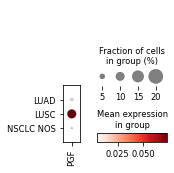

In [17]:
sc.pl.dotplot(
    adata_primary_tumor[adata_primary_tumor.obs["cell_type_major"] == "Tumor cells", :],
    var_names=["PGF"],
    groupby="condition",
)

In [29]:
cpdb_res = cpdba.significant_interactions(
    de_res_tumor_cells_luad_lusc, max_pvalue=0.1
)
cpdb_res = cpdb_res.loc[lambda x: x["cell_type_major"].isin(immune_cells)]
top_genes = (
    cpdb_res.loc[:, ["source_genesymbol", "fdr"]]
    .drop_duplicates()
    .sort_values("fdr")["source_genesymbol"][:30]
    .tolist()
)
# cpdb_res.to_csv(f"{artifact_dir}/cpdb_luad_lusc.csv")
cpdba.plot_result(
    cpdb_res.loc[lambda x: x["source_genesymbol"].isin(top_genes)],
    title="LUAD vs LUSC: tumor cells, top 30 DE ligands",
    aggregate=False,
    cluster="heatmap",
    label_limit=80,
)

alt.VConcatChart(...)

# Patient stratification

In [19]:
de_res_tumor_cells_patient_strat = (
    pd.read_csv(
        (
            deseq2_path_prefix
            + "/{comparison}_primary_tumor_adata_primary_tumor_tumor_cells_DESeq2_result.tsv"
        ).format(comparison="immune_infiltration"),
        sep="\t",
    )
    .fillna(1)
    .pipe(sh.util.fdr_correction)
    .rename(columns={"comparison": "group"})
)

In [20]:
cpdb_res = cpdba.significant_interactions(
    de_res_tumor_cells_patient_strat, max_pvalue=1
)
# readjust FDR after subsetting immune cells
cpdb_res = (
    cpdb_res.loc[lambda x: x["cell_type_major"].isin(immune_cells)]
    .pipe(sh.util.fdr_correction)
    .loc[
        lambda x: x["source_genesymbol"].isin(
            x.loc[lambda y: y["fdr"] < 0.1, "source_genesymbol"]
        )
    ]
    .copy()
)
cpdb_res.to_csv(f"{artifact_dir}/cpdb_patient_stratification.csv")
cpdba.plot_result(
    cpdb_res,
    title="Patient stratification: tumor cells, ligand FDR < 0.1",
    aggregate=False,
    cluster="heatmap",
    clip_fc_at=(-3, 3),
)

alt.VConcatChart(...)

In [21]:
cpdb_res

cell_type_major  fraction_expressed  expr_mean  source  target  \
8         Macrophage            0.361522   4.578200  P80098  P32246   
9         Macrophage            0.361522   4.578200  P80098  P32246   
10        Macrophage            0.361522   4.578200  P80098  P32246   
11        Macrophage            0.361522   4.578200  P80098  P32246   
12          Monocyte            0.185568   4.002221  P80098  P32246   
...              ...                 ...        ...     ...     ...   
2923            cDC1            0.294964   3.735461  O95971  Q92956   
2928       DC mature            0.364994   4.401355  O95971  Q92956   
2929       DC mature            0.364994   4.401355  O95971  Q92956   
2930       DC mature            0.364994   4.401355  O95971  Q92956   
2931       DC mature            0.364994   4.401355  O95971  Q92956   

     source_genesymbol target_genesymbol  is_directed  is_stimulation  \
8                 CCL7              CCR1            1               1   
9                 CCL7              CCR1            1               1   
10                CCL7              CCR1            1               1   
11                CCL7              CCR1            1               1   
12                CCL7              CCR1            1               1   
...                ...               ...          ...             ...   
2923             CD160          TNFRSF14            1               0   
2928             CD160          TNFRSF14            1               0   
2929             CD160          TNFRSF14            1               0   
2930             CD160          TNFRSF14            1               0   
2931             CD160          TNFRSF14            1               0   

      is_inhibition  ...  baseMean  log2FoldChange     lfcSE      stat  \
8                 0  ...  0.259975        0.085826  0.835389  0.102737   
9                 0  ...  0.259975       -1.760249  0.754486 -2.333043   
10                0  ...  0.259975        1.042650  0.800819  1.301978   
11                0  ...  0.259975        0.210591  0.261968  0.803881   
12                0  ...  0.259975        0.085826  0.835389  0.102737   
...             ...  ...       ...             ...       ...       ...   
2923              0  ...  0.957096        0.249889  0.174232  1.434234   
2928              0  ...  0.957096        0.265892  0.553002  0.480815   
2929              0  ...  0.957096       -1.118818  0.498644 -2.243722   
2930              0  ...  0.957096        0.103260  0.538196  0.191863   
2931              0  ...  0.957096        0.249889  0.174232  1.434234   

        pvalue      padj    weight   group       fdr     interaction  
8     0.918171  1.000000  0.273758       B  0.955837       CCL7_CCR1  
9     0.019646  1.000000  0.000000  desert  0.086397       CCL7_CCR1  
10    0.192924  1.000000  0.290328       M  0.395578       CCL7_CCR1  
11    0.421466  0.985513  1.000000       T  0.686352       CCL7_CCR1  
12    0.918171  1.000000  0.273758       B  0.955837       CCL7_CCR1  
...        ...       ...       ...     ...       ...             ...  
2923  0.151506  1.000000  0.000000       T  0.356941  CD160_TNFRSF14  
2928  0.630648  1.000000  0.184678       B  0.852019  CD160_TNFRSF14  
2929  0.024850  0.265322  0.387112  desert  0.098637  CD160_TNFRSF14  
2930  0.847849  1.000000  0.250648       M  0.920454  CD160_TNFRSF14  
2931  0.151506  1.000000  0.000000       T  0.356941  CD160_TNFRSF14  

[888 rows x 25 columns]

# Neutrophils

In [22]:
de_res_neutro_clusters = (
    pd.read_csv(
        (deseq2_path_neutro_clusters).format(comparison="immune_infiltration"),
        sep="\t",
    )
    .fillna(1)
    .pipe(sh.util.fdr_correction)
    .rename(columns={"comparison": "group"})
)

In [23]:
de_res_neutro_clusters

gene_id     baseMean  log2FoldChange     lfcSE       stat  \
0          C2orf80     0.339507      -30.000000  1.187885 -25.254961   
1           S100A8  1871.571508        1.857575  0.116489  15.946352   
2             MMP9    24.873998        3.022370  0.196238  15.401592   
3           CCL4L2   289.344318       -5.195247  0.390562 -13.301982   
4       AC006449.2     0.261835      -19.199833  1.509657 -12.718009   
...            ...          ...             ...       ...        ...   
114417         ZP1     0.002010        0.080915  0.772222   0.104782   
114418     ZSCAN22     0.051558        0.060148  0.550418   0.109278   
114419      ZSWIM3     0.322870        0.186717  0.570171   0.327475   
114420      ZSWIM9     0.419348        0.163061  0.200660   0.812623   
114421      ZWILCH     0.369021        0.148554  0.230440   0.644653   

               pvalue           padj    weight  group            fdr  
0       9.990061e-141  1.504668e-134  0.010197  NAN-1  5.715414e-136  
1        3.020300e-57   1.434943e-53  1.616398  NAN-1   2.468491e-53  
2        1.596887e-53   5.202655e-50  1.571415  NAN-1   1.141994e-49  
3        2.254128e-40   5.577456e-37  1.551834  NAN-1   1.228199e-36  
4        4.696761e-37   3.731542e-31  0.002762  NAN-1   2.066972e-33  
...               ...            ...       ...    ...            ...  
114417   1.000000e+00   1.000000e+00  1.000000  TAN-4   1.000000e+00  
114418   1.000000e+00   1.000000e+00  1.000000  TAN-4   1.000000e+00  
114419   1.000000e+00   1.000000e+00  1.000000  TAN-4   1.000000e+00  
114420   1.000000e+00   1.000000e+00  1.000000  TAN-4   1.000000e+00  
114421   1.000000e+00   1.000000e+00  1.000000  TAN-4   1.000000e+00  

[114422 rows x 10 columns]

In [24]:
cpdb_res = cpdba.significant_interactions(de_res_neutro_clusters, max_pvalue=0.1)
cpdb_res.to_csv(f"{artifact_dir}/cpdb_neutro_clusters.csv")
cpdba.plot_result(
    cpdb_res.loc[lambda x: x["cell_type_major"].isin(["Tumor cells", "T cell CD8"])],
    title="Patient stratification: tumor cells, ligand FDR < 0.1",
    aggregate=False,
    cluster="heatmap",
    de_genes_mode="ligand",
    clip_fc_at=(-3, 3),
).configure_concat(spacing=0)

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scanpy_helpers/cell2cell.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpdb_res[fc_col] = np.clip(cpdb_res[fc_col], *clip_fc_at)
/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scanpy_helpers/cell2cell.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpdb_res["interaction"] = [


alt.VConcatChart(...)

In [25]:
cpdb_res = cpdba.significant_interactions(de_res_neutro_clusters, max_pvalue=0.01)
cpdb_res.to_csv(f"{artifact_dir}/cpdb_neutro_clusters.csv")
cpdba.plot_result(
    cpdb_res.loc[lambda x: x["cell_type_major"].isin(["Tumor cells", "T cell CD8"])],
    title="Patient stratification: tumor cells, ligand FDR < 0.01",
    aggregate=False,
    cluster="heatmap",
    de_genes_mode="ligand",
    clip_fc_at=(-3, 3),
).configure_concat(spacing=0)

alt.VConcatChart(...)

In [26]:
cpdb_res = cpdba.significant_interactions(
    de_res_neutro_clusters, max_pvalue=0.1, de_genes_mode="receptor"
)
cpdb_res.to_csv(f"{artifact_dir}/cpdb_neutro_clusters.csv")
cpdba.plot_result(
    cpdb_res.loc[lambda x: x["cell_type_major"].isin(["Tumor cells"])],
    title="Neutrophil clusters: incoming interactions, receptor FDR < 0.1; abs(log2FC) > 1",
    aggregate=False,
    cluster="heatmap",
    de_genes_mode="receptor",
    label_limit=100,
    clip_fc_at=(-3, 3),
).configure_concat(spacing=-80)

alt.VConcatChart(...)